# Below are the step by step procedures I followed to complete my project. 

### Step 0: Importing Moduls

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Step 1: Read in the Dynamic Spectru,

In [2]:
"""Reading in the Dynamic Spectrum"""
import numpy as np
import astropy.units as u 
'''Load the dynamic spectra'''
dir = '/mnt/scratch-lustre/simard/b0834/data/'
nt = 660
nf = 16384*4
I = np.zeros([2, nf, nt], dtype=complex)
for i in range(4):
    for g in ['0', '1', '6']:
        I[0,i*nf//4:(i+1)*nf//4, :] += np.fromfile(dir+'/Ar-Ar/freq0'+str(i)+'/gate'+g+'.bin',
                                                  np.float32).reshape(-1,nf//4).T
        I[1, i*nf//4:(i+1)*nf//4, :] += np.fromfile(dir+'/Gb-Gb/freq0'+str(i)+'/gate'+g+'.bin',
                                                   np.float32).reshape(-1,nf//4).T
f = (np.arange(nf)*8.*4./nf+310.5)*u.MHz # Frequencies in Megahurtz-> For secondary spectrum
t = (np.arange(nt)*6729./nt)*u.s # Time in Secondss

# I[0] is data for the Aricebo Dynamic Telescope
# I[1] is data for the Greenbank Telescope

### Step 2: Plot the Dynamic Spectrums

In [3]:
# Seperate Arecibo and Greenbank data. Thank divided the average absolute value along the frequency axis.
# The reasoning behind this is explained in the pdf.
arc = I[0, ...]
grb = I[1, ...]
arc = arc / np.abs(arc).mean(axis = 1, keepdims=True)
grb = grb / np.abs(grb).mean(axis = 1, keepdims=True)

In [4]:
# Rebin the dynamic spectrums for plotting. These rebinned matrices are only used for plotting. Calculations
# are done with the initial matrices.
arc=arc.reshape(256,arc.shape[0]//256,arc.shape[1]//1,-1).mean(axis=3).mean(axis=1)
grb=grb.reshape(256,grb.shape[0]//256,grb.shape[1]//1,-1).mean(axis=3).mean(axis=1)

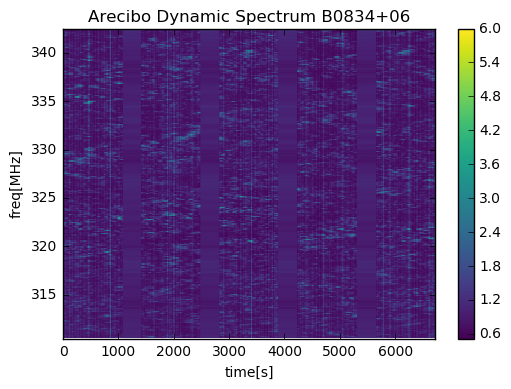

In [8]:
# Make the graph for Arecibo Dynamic Spectrum
# Note that this saves a pdf of the figure in the directory titled Arecibo_Dynamic.pdf

plt.imshow(np.abs(arc), interpolation = 'none', origin = 'lower',
           aspect = 'auto', vmax = 6, extent = [t.min().value, t.max().value, f.min().value, f.max().value], cmap = 'viridis')

plt.title("Arecibo Dynamic Spectrum B0834+06")
plt.xlabel('time[s]')
plt.ylabel('freq[MHz]')
plt.colorbar()
plt.savefig("Arecibo_Dynamic.pdf")

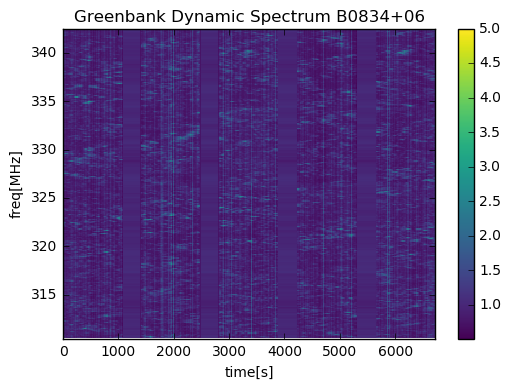

In [9]:
# Will repeat the same thing for the Greenbank Telescope

plt.imshow(np.abs(grb), interpolation = 'none', origin = 'lower',
           aspect = 'auto', vmax = 5, extent = [t.min().value, t.max().value, f.min().value, f.max().value], cmap = 'viridis')

plt.title("Greenbank Dynamic Spectrum B0834+06")
plt.xlabel('time[s]')
plt.ylabel('freq[MHz]')
plt.colorbar()
plt.savefig("Greenbank_Dynamic.pdf")

### Step 3: Get the cross secondary spectrum (2D fft) of Arecibo and Greenbank Dynamic Spectrum

In [18]:
# Simply use numpy to apply to 2D fast fourier transform

arcfft = np.fft.fft2(I[0, :, :])
grbfft = np.fft.fft2(I[1, :, :])
arc.shape

(256, 660)

In [19]:
# Re-center the origins:
arcfft = np.fft.fftshift(arcfft, axes = (0,))
arcfft = np.fft.fftshift(arcfft, axes = (1,))
grbfft = np.fft.fftshift(grbfft, axes = (0,))
grbfft = np.fft.fftshift(grbfft, axes = (1,))

In [20]:
# Make the amplitude and phase shift graphs:
raw = arcfft*np.conj(grbfft)
amp = np.log10(np.abs(arcfft*np.conj(grbfft)))
phi = np.angle(arcfft*np.conjugate(grbfft))  # This one is only for graphing purposes. DO NOT TAKE AVERAGES OF PHASES
#phi[(phi > -0.5) & (phi < 0.5)] = np.nan

In [21]:
# Rebin secondary septra
# amp1 = amp.reshape(256,amp.shape[0]//256,amp.shape[1]//1,-1).mean(axis=3).mean(axis=1)
amp1 = amp.reshape((-1,128,amp.shape[-1])).mean(axis=1)
amp2 = amp1.reshape((-1,2,amp1.shape[-1])).mean(axis=1)
phi1 = phi.reshape(256,phi.shape[0]//256,phi.shape[1]//1,-1).mean(axis=3).mean(axis=1)


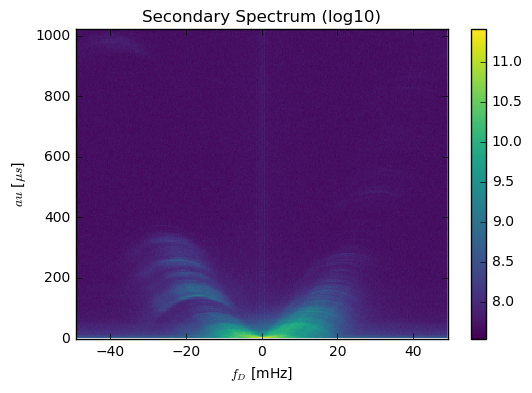

In [22]:
# This first plot shows the log10 of the absolute value of the secondary spectrum
# Will be saved as a pdf as Secondary_Spectrum_log10.pdf
# Plot only shows positive time delays

plt.imshow(amp1[256:, :], interpolation = 'none', origin = 'lower',
           aspect = 'auto', cmap = 'viridis', extent = [-49.1159136, 49.1159136, 0, 1024.015625])
plt.title("Secondary Spectrum (log10)")
plt.xlabel("$f_D$ [mHz]")
plt.ylabel("$\tau$ [$\mu s$]")
plt.colorbar()
plt.savefig("Secondary_Spectrum_log10.pdf")

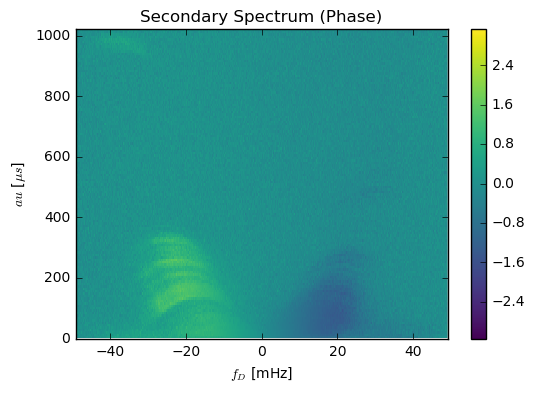

In [23]:
# This second plot measures the phase of the secondary spectrum
# Will be saved as a pdf as Secondary_Spectrum_Phase.pdf
# Plot only shows positive time delays

plt.imshow(phi1[128:, :], interpolation = 'none', origin = 'lower',
           aspect = 'auto', cmap = 'viridis', vmin = -np.pi, vmax = np.pi, extent = [-49.1159136, 49.1159136, 0, 1024.015625])
plt.title("Secondary Spectrum (Phase)")
plt.xlabel("$f_D$ [mHz]")
plt.ylabel("$\tau$ [$\mu s$]")
plt.colorbar()
plt.savefig("Secondary_Spectrum_Phase.pdf")

### Calculate average phase as a function of Doppler Shift

Slope =  -72.7496966708


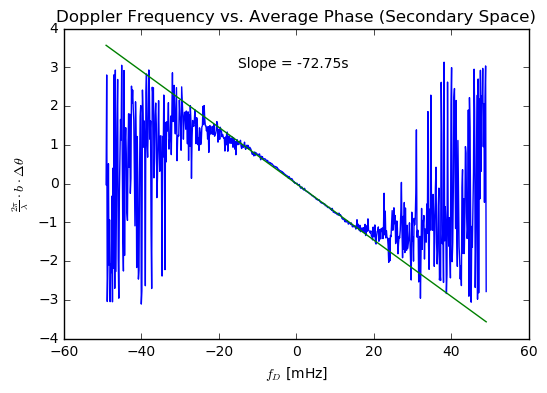

In [33]:
# Took average of complex values (only for positive time delays) for each frequency. Then took the phase
# Used np.polyfit to extrapolate a one dimensional graph.
# Data points in the upper and lower third of frequencies were ignored when estimating the function
# Noise at low frequencies are due to the milisecond feature of the pulsar.
# Simply too much noise at higher frequencies

b = (np.arange(660) - 330)*(49.1159136/330)
cut_time = np.arange(100, 500)
linear_plot = np.mean(raw[32768:, :], axis = 0)
a = np.angle(linear_plot)
fit = np.polyfit(b[220:420], a[220:420], 1)
plt.plot(b, a)
plt.title("Doppler Frequency vs. Average Phase (Secondary Space)")
plt.xlabel("$f_D$ [mHz]")
plt.ylabel(r'$\frac{2 \pi}{\lambda} \cdot b \cdot \Delta \theta $')
plt.plot(b, fit[0]*b + fit[1])
plt.text(-15, 3, "Slope = -72.75s")
print("Slope = ", fit[0]*1000)
plt.savefig("Frequency_Phase.pdf")

/opt/python/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


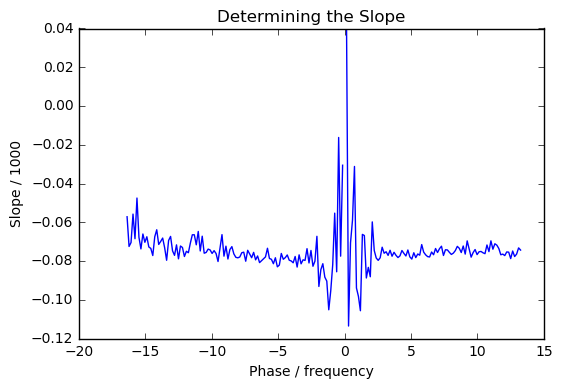

In [43]:
# Attempting to get an error for my slope
fit_values = a[220:420]
fit_domain = b[220:420]
plt.plot(fit_domain, fit_values/fit_domain)
plt.xlabel("Phase / frequency")
plt.ylabel("Slope / 1000")
plt.title("Determining the Slope")
plt.savefig("Slope")

### Step 4: Calculate the slope divided by $2 \pi$

In [37]:
time_delay = fit[0]*1000 / (2*np.pi)
print("The time delay between Arecibo and Greenbank is:", time_delay, "s")

The time delay between Arecibo and Greenbank is: -11.5784738336 s


/opt/python/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


inf